In [40]:
import re
#import matplotlib
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
#nltk.download("stopwords")
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [5]:
q=pd.read_csv('Questions.csv', encoding='latin-1')
t=pd.read_csv('Tags.csv')

In [6]:
#drop unnecessary columns
q=q.drop(q.columns[[1,2,3,4,5]], axis=1)
q.head(3)

,Id,Body
0,80,<p>I've written a database generation script i...
1,90,<p>Are there any really good tutorials explain...
2,120,<p>Has anyone got experience creating <strong>...


In [7]:
# function of text cleaning
def clean_text(text):
    #erasing code syntax
    text = re.sub('<pre>.*?</pre>', '', text, flags=re.DOTALL)
    text = re.sub('<[^>]+>', '', text, flags=re.DOTALL)
    #eliminate duplicate spaces
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    #lower case
    text = text.lower()
    #replacing abbreviation for stopword removing
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    return text

In [8]:
q['Text'] = q['Body'].apply(clean_text)

In [22]:
# examples of cleaned texts
pd.set_option('display.max_colwidth', -1)
q[1:3]

,Id,Body,Text
1,90,"<p>Are there any really good tutorials explaining <a href=""http://svnbook.red-bean.com/en/1.8/svn.branchmerge.html"" rel=""nofollow"">branching and merging</a> with Apache Subversion? </p>\n\n<p>All the better if it's specific to TortoiseSVN client.</p>\n",are there any really good tutorials explaining branching and merging with apache subversion? all the better if it specific to tortoisesvn client.
2,120,"<p>Has anyone got experience creating <strong>SQL-based ASP.NET</strong> site-map providers?</p>\n\n<p>I've got the default XML file <code>web.sitemap</code> working properly with my Menu and <strong>SiteMapPath</strong> controls, but I'll need a way for the users of my site to create and modify pages dynamically.</p>\n\n<p>I need to tie page viewing permissions into the standard <code>ASP.NET</code> membership system as well.</p>\n","has anyone got experience creating sql-based asp.net site-map providers? i have got the default xml file web.sitemap working properly with my menu and sitemappath controls, but i will need a way for the users of my site to create and modify pages dynamically. i need to tie page viewing permissions into the standard asp.net membership system as well."


In [23]:
# back to default setting
pd.reset_option('display.max_colwidth', 0)

In [27]:
#merge the questions with tags according the ids
tq = t.merge(q, how = 'inner', on = ['Id'])
#drop the original text
tq=tq.drop(tq.columns[[2]], axis=1)
#selecting rows of the top 10 tags
tq = tq[(tq.Tag == 'javascript') | (tq.Tag == 'java') | (tq.Tag == 'c#') | (tq.Tag =='php') | (tq.Tag =='android') | (tq.Tag == 'jquery') | (tq.Tag == 'python') | (tq.Tag == 'html') | (tq.Tag == 'c++') | (tq.Tag == 'ios')]
tq.head(3)

,Id,Tag,Text
14,260,c#,i have a little game written in c#. it uses a ...
18,330,c++,i am working on a collection of classes used f...
28,650,c#,i would like the version property of my applic...


In [28]:
tags=['javascript', 'java', 'c#', 'php', 'android', 'jquery', 'python', 'html', 'c++', 'ios']

In [29]:
#Separate the dataset into training and testing set into 0.8/0.2.
text_train, text_test, tag_train, tag_test = train_test_split(tq['Text'], tq['Tag'], random_state=1, test_size=0.2, shuffle=True)

In [30]:
print("Extracting features from the training data")
t0=time()
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,stop_words='english')
tfidf_train = vectorizer.fit_transform(text_train)
duration = time() - t0
print("Vectorizing and TF-IDF done in %fs" % (duration))
print("trainging_samples: %d, n_features: %d" % tfidf_train.shape)

Extracting features from the training data
Vectorizing and TF-IDF done in 40.985812s
trainging_samples: 661391, n_features: 562034


In [31]:
print("Extracting features from the testing data using the same vectorizer")
t0 = time()
tfidf_test = vectorizer.transform(text_test)
duration = time() - t0
print("done in %fs " % (duration))
print("testing_samples: %d, n_features: %d" % tfidf_test.shape)

Extracting features from the testing data using the same vectorizer
done in 10.968276s 
testing_samples: 165348, n_features: 562034


In [36]:
#Ridge Classifier
t0=time()
model_RC = RidgeClassifier(tol=0.01, solver="sag")
model_RC.fit(tfidf_train, tag_train)
t1=time()
predicted_RC = model_RC.predict(tfidf_test)
t2 = time()
RCtrain_time=t1-t0
RCtest_time=t2-t1
RCscore = f1_score(tag_test, predicted_RC,average='weighted')
RCscorelist = f1_score(tag_test, predicted_RC,average=None)
print("Training done in %fs " % (t1-t0))
print("Prediction done in %fs " % (t2-t1))
print("Average F1-score%d " % (RCscore))
print(classification_report(tag_test, predicted_RC))

Training done in 142.353462s 
Prediction done in 0.211680s 
Average F1-score0 
             precision    recall  f1-score   support

    android       0.76      0.81      0.78     18400
         c#       0.74      0.77      0.76     20099
        c++       0.80      0.70      0.75      9543
       html       0.48      0.36      0.41     11954
        ios       0.89      0.82      0.85      9251
       java       0.71      0.74      0.72     23062
 javascript       0.52      0.55      0.53     24920
     jquery       0.45      0.39      0.42     15690
        php       0.68      0.79      0.73     19625
     python       0.85      0.80      0.82     12804

avg / total       0.67      0.67      0.67    165348



In [37]:
#Stochastic Gradient Descent Classifier
t0=time()
model_SGDC = SGDClassifier(alpha=0.0001, max_iter=100,penalty="elasticnet")
#model_SGDC = SGDClassifier(alpha=.0001, n_iter=50,penalty="elasticnet")
model_SGDC.fit(tfidf_train, tag_train)
t1=time()
predicted_SGDC = model_SGDC.predict(tfidf_test)
t2 = time()
SGDCtrain_time=t1-t0
SGDCtest_time=t2-t1
SGDCscore = f1_score(tag_test, predicted_SGDC,average='weighted')
SGDCscorelist = f1_score(tag_test, predicted_SGDC,average=None)
print("Training done in %fs " % (t1-t0))
print("Prediction done in %fs " % (t2-t1))
print("Average F1-score%d " % (SGDCscore))
print(classification_report(tag_test, predicted_SGDC))

Training done in 377.898348s 
Prediction done in 0.104385s 
Average F1-score0 
             precision    recall  f1-score   support

    android       0.70      0.84      0.76     18400
         c#       0.64      0.75      0.69     20099
        c++       0.69      0.66      0.67      9543
       html       0.55      0.25      0.34     11954
        ios       0.77      0.81      0.79      9251
       java       0.73      0.68      0.70     23062
 javascript       0.57      0.57      0.57     24920
     jquery       0.50      0.41      0.45     15690
        php       0.63      0.82      0.72     19625
     python       0.86      0.73      0.79     12804

avg / total       0.66      0.66      0.65    165348



In [38]:
#Mulitinomial Naive Bayes Classifier
t0=time()
model_MNB = MultinomialNB(alpha=0.05)
model_MNB.fit(tfidf_train, tag_train)
t1=time()
predicted_MNB = model_MNB.predict(tfidf_test)
t2 = time()
MNBtrain_time=t1-t0
MNBtest_time=t2-t1
MNBscore = f1_score(tag_test, predicted_MNB,average='weighted')
MNBscorelist=f1_score(tag_test, predicted_MNB,average=None)
print("Training done in %fs " % (t1-t0))
print("Prediction done in %fs " % (t2-t1))
print("Average F1-score %f " % (MNBscore))
print(classification_report(tag_test, predicted_MNB))

Training done in 2.945560s 
Prediction done in 0.109897s 
Average F1-score 0.611853 
             precision    recall  f1-score   support

    android       0.73      0.74      0.74     18400
         c#       0.77      0.68      0.72     20099
        c++       0.79      0.64      0.70      9543
       html       0.44      0.31      0.37     11954
        ios       0.93      0.71      0.80      9251
       java       0.64      0.70      0.67     23062
 javascript       0.42      0.56      0.48     24920
     jquery       0.35      0.27      0.30     15690
        php       0.60      0.73      0.66     19625
     python       0.79      0.70      0.74     12804

avg / total       0.62      0.61      0.61    165348



In [41]:
#Logistic Regression Classifier
t0=time()
model_LR = LogisticRegression(solver='sag')
model_LR.fit(tfidf_train, tag_train)
t1=time()
predicted_LR = model_LR.predict(tfidf_test)
t2 = time()
LRtrain_time=t1-t0
LRtest_time=t2-t1
LRscore = f1_score(tag_test, predicted_LR,average='weighted')
LRscorelist=f1_score(tag_test, predicted_LR,average=None)
print("Training done in %fs " % (t1-t0))
print("Prediction done in %fs " % (t2-t1))
print("Average F1-score%d " % (LRscore))
print(classification_report(tag_test, predicted_LR))

Training done in 171.057110s 
Prediction done in 0.190120s 
Average F1-score0 
             precision    recall  f1-score   support

    android       0.78      0.81      0.79     18400
         c#       0.73      0.78      0.76     20099
        c++       0.79      0.72      0.75      9543
       html       0.52      0.40      0.46     11954
        ios       0.88      0.82      0.85      9251
       java       0.73      0.74      0.74     23062
 javascript       0.56      0.59      0.57     24920
     jquery       0.50      0.43      0.47     15690
        php       0.71      0.80      0.75     19625
     python       0.84      0.81      0.83     12804

avg / total       0.69      0.69      0.69    165348



In [42]:
#Linear Support Vector Classifier
t0=time()
model_SVC = LinearSVC()
model_SVC.fit(tfidf_train, tag_train)
t1=time()
predicted_SVC = model_SVC.predict(tfidf_test)
t2 = time()
SVCtrain_time=t1-t0
SVCtest_time=t2-t1
SVCscore = f1_score(tag_test, predicted_SVC,average='weighted')
SVCscorelist=f1_score(tag_test, predicted_SVC,average=None)
print("Training done in %fs " % (t1-t0))
print("Prediction done in %fs " % (t2-t1))
print("Average F1-score%d " % (SVCscore))
print(classification_report(tag_test, predicted_SVC))

Training done in 85.853485s 
Prediction done in 0.110952s 
Average F1-score0 
             precision    recall  f1-score   support

    android       0.75      0.79      0.77     18400
         c#       0.75      0.77      0.76     20099
        c++       0.77      0.74      0.75      9543
       html       0.45      0.36      0.40     11954
        ios       0.86      0.83      0.85      9251
       java       0.72      0.72      0.72     23062
 javascript       0.51      0.52      0.51     24920
     jquery       0.41      0.37      0.39     15690
        php       0.69      0.77      0.73     19625
     python       0.82      0.82      0.82     12804

avg / total       0.66      0.67      0.66    165348



In [43]:
#Multilayer Perceptron Classifier
t0=time()
model_MLPC = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(15, 8), random_state=1)
model_MLPC.fit(tfidf_train, tag_train)
t1=time()
predicted_MLPC = model_MLPC.predict(tfidf_test)
t2 = time()
MLPCtrain_time=t1-t0
MLPCtest_time=t2-t1
MLPCscore = f1_score(tag_test, predicted_MLPC,average='weighted')
MLPCscorelist=f1_score(tag_test, predicted_MLPC,average=None)
print("Training done in %fs " % (t1-t0))
print("Prediction done in %fs " % (t2-t1))
print("Average F1-score%d " % (MLPCscore))
print(classification_report(tag_test, predicted_MLPC))

Training done in 365.583890s 
Prediction done in 0.506188s 
Average F1-score0 
             precision    recall  f1-score   support

    android       0.78      0.73      0.76     18400
         c#       0.67      0.72      0.70     20099
        c++       0.75      0.62      0.68      9543
       html       0.54      0.30      0.38     11954
        ios       0.81      0.77      0.79      9251
       java       0.65      0.71      0.68     23062
 javascript       0.48      0.65      0.56     24920
     jquery       0.48      0.30      0.37     15690
        php       0.66      0.73      0.70     19625
     python       0.77      0.77      0.77     12804

avg / total       0.64      0.64      0.64    165348



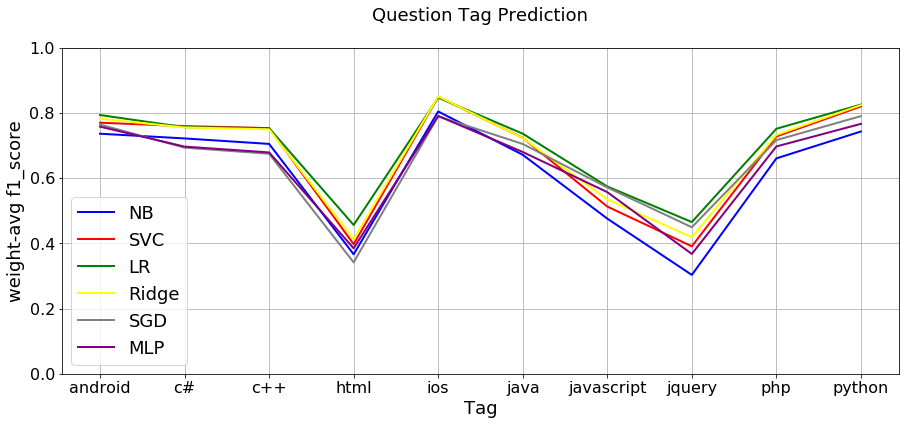

In [44]:
xx=['android','c#','c++','html','ios','java','javascript','jquery','php', 'python']
df=pd.DataFrame({'x': xx, 'MNB': MNBscorelist, 'SVC':SVCscorelist , 'LR': LRscorelist , 'RC': RCscorelist,'SGDC': SGDCscorelist, 'MLPC': MLPCscorelist})
# multiple line plot
plt.figure(num=None, figsize=(15, 6))
plt.plot( 'x', 'MNB', data=df, marker='', color='blue', linewidth=2, label="NB")
plt.plot( 'x', 'SVC', data=df, marker='', color='red', linewidth=2, label="SVC")
plt.plot( 'x', 'LR', data=df, marker='', color='green', linewidth=2, label="LR")
plt.plot( 'x', 'RC', data=df, marker='', color='yellow', linewidth=2, label="Ridge")
plt.plot( 'x', 'SGDC', data=df, marker='', color='gray', linewidth=2, label="SGD")
plt.plot( 'x', 'MLPC', data=df, marker='', color='purple', linewidth=2, label="MLP")
plt.grid()
plt.legend(fontsize=18)
plt.ylim((0,1))
plt.title("Question Tag Prediction\n", fontsize=18)
plt.ylabel('weight-avg f1_score', fontsize=18)
plt.xlabel('Tag', fontsize=18)
plt.tick_params(labelsize=16)